In [1]:
'''
Demonstrating basic models for predicting VAD - Valence, Activation, Dominance - dimensions of emotion
'''

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Storage
import pickle
from sklearn.externals import joblib

'''
Sources:
https://www.dataquest.io/blog/natural-language-processing-with-python/
https://heartbeat.fritz.ai/guide-to-saving-hosting-your-first-machine-learning-model-cdf69729e85d
'''

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import Ridge

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import data, set up train and test splits
with open('/Volumes/COLESLAW_1TB/BELL_LABS/unique_wavs_VAD_transcriptions.data',
          'rb') as filehandle:
    # read the data as binary data stream
    unique_wavs_VAD_trans = pickle.load(filehandle)

# check data for null values
unique_wavs_VAD_trans.isnull().sum()

# split into train and test splits
X_train, X_test, y_train_val, y_test_val =\
train_test_split(unique_wavs_VAD_trans['transcription'],
                 unique_wavs_VAD_trans['label_val'],
                 test_size=0.2,
                 random_state=42)

X_train, X_test, y_train_act, y_test_act =\
train_test_split(unique_wavs_VAD_trans['transcription'],
                 unique_wavs_VAD_trans['label_act'],
                 test_size=0.2,
                 random_state=42)

X_train, X_test, y_train_dom, y_test_dom =\
train_test_split(unique_wavs_VAD_trans['transcription'],
                 unique_wavs_VAD_trans['label_dom'],
                 test_size=0.2,
                 random_state=42)

In [3]:
'''
Clean & lemmatize data
'''

def clean_lemma(text):
    
    corpus = []
    
    for i in range(0, text.shape[0]):
        review = re.sub('[^a-zA-Z]', ' ', text[i])
        review = review.lower()
        review = review.split()
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

data_training = clean_lemma(X_train)
data_test = clean_lemma(X_test)

In [4]:
'''
Feature Selection
'''
# From:
# https://heartbeat.fritz.ai/guide-to-saving-hosting-your-first-machine-learning-model-cdf69729e85d
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(max_features=1000,
                                  lowercase=True,
                                  stop_words="english",
                                  ngram_range=(1,2))

X = tfidfVectorizer.fit_transform(data_training).toarray()
x = tfidfVectorizer.transform(data_test).toarray()

'''
Save vectorizer for online deployment
'''

# joblib.dump(tfidfVectorizer, 'vect_obj_iemocap.pkl')

'\nSave vectorizer for online deployment\n'

In [5]:
'''
Function to run some metrics
'''

from scipy.stats import pearsonr, spearmanr

def print_preds_errors_plots(preds, labels, plot_title):
    '''
    Calculate errors and correlations. Run a plot.
    '''
    # comparing predicted with actual
    print('Prediction error: ', sum(abs(preds - labels)) / len(preds))
    
    # average of all Valence ratings
    average_all_measure = sum(labels)/len(labels)
    print('Mean error: ', sum(abs(average_all_measure - labels)) / len(preds))
    
    # calculate pearson's correlation
    corr, _ = pearsonr(preds, labels)
    print('Pearsons correlation: %.3f' % corr)
    
    # calculate spearman's correlation
    corr, _ = spearmanr(preds, labels)
    print('Spearmans correlation: %.3f' % corr)
    
    #sns.distplot(preds)
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,12))
    fig = sns.regplot(x=preds, y=labels, label=plot_title)
    #fig.set_axis_labels(xlabel='Predictions', ylabel='Actual')
    
    plt.title(plot_title)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.xlim((0, 5.5))
    plt.ylim((0, 5.5))
    plt.show(fig)

In [6]:
'''
Set up training, dev and test sets for each of V, A, D.
'''

# setup train and dev splits
data_train = X[:6500, :]
data_dev = X[6500:, :]
data_test = x
data_training = X

# Valence Labels
lab_train_V = y_train_val[:6500]
lab_dev_V = y_train_val[6500:]
lab_training_V = y_train_val
lab_test_V = y_test_val

# Activation Labels
lab_train_A = y_train_act[:6500]
lab_dev_A = y_train_act[6500:]
lab_training_A = y_train_act
lab_test_A = y_test_act

# Dominance Labels
lab_train_D = y_train_dom[:6500]
lab_dev_D = y_train_dom[6500:]
lab_training_D = y_train_dom
lab_test_D = y_test_dom

data_train = np.nan_to_num(data_train)
data_dev = np.nan_to_num(data_dev)
data_test = np.nan_to_num(data_test)
data_training = np.nan_to_num(data_training)

Prediction error:  0.583968558882469
Mean error:  0.7537916064824376
Pearsons correlation: 0.566
Spearmans correlation: 0.545


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


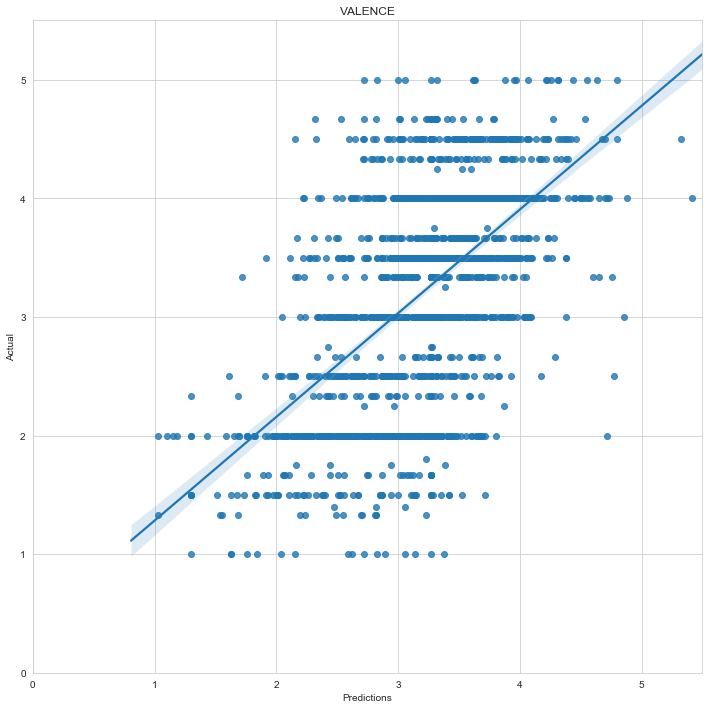

In [7]:
'''
VALENCE
'''
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
from sklearn.neural_network import MLPRegressor
# from sklearn.tree import DecisionTreeRegressor

# Run the regression and generate predictions for the dev set
# reg_V = Ridge(alpha=0.1)
# reg_V = MLPRegressor(max_iter=300, verbose=True)
# reg_V = DecisionTreeRegressor(random_state=12)
# reg_V.fit(data_train, lab_train_V)
# predictions_V = reg_V.predict(data_dev)
# Print prediction error and plot distribution - dev
# print_preds_errors_plots(predictions_V, lab_dev_V, "VALENCE")

# Test set
reg_V = Ridge(alpha=.1)
reg_V.fit(data_training, lab_training_V)
predictions_V = reg_V.predict(data_test)
# Print prediction error and plot distribution - test
print_preds_errors_plots(predictions_V, lab_test_V, "VALENCE")

Prediction error:  0.5231369807905278
Mean error:  0.5550054016999744
Pearsons correlation: 0.374
Spearmans correlation: 0.348


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


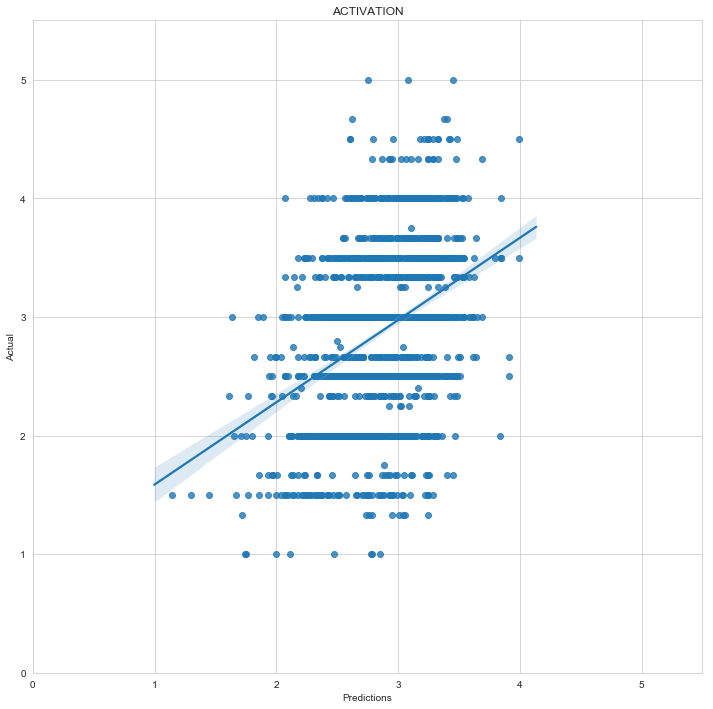

In [9]:
'''
ACTIVATION
'''
# Run the regression and generate predictions for the dev set
# reg_A = Ridge(alpha=.1)
# reg_A.fit(data_train, lab_train_A)
# predictions_A = reg_A.predict(data_dev)
# Print prediction error and plot distribution
# print_preds_errors_plots(predictions_A, lab_dev_A, "ACTIVATION")

# Test set
reg_A = Ridge(alpha=.1)
reg_A.fit(data_training, lab_training_A)
predictions_A = reg_A.predict(data_test)
# Print prediction error and plot distribution - test
print_preds_errors_plots(predictions_A, lab_test_A, "ACTIVATION")

Prediction error:  0.5757004438814538
Mean error:  0.6317628804172413
Pearsons correlation: 0.386
Spearmans correlation: 0.370


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


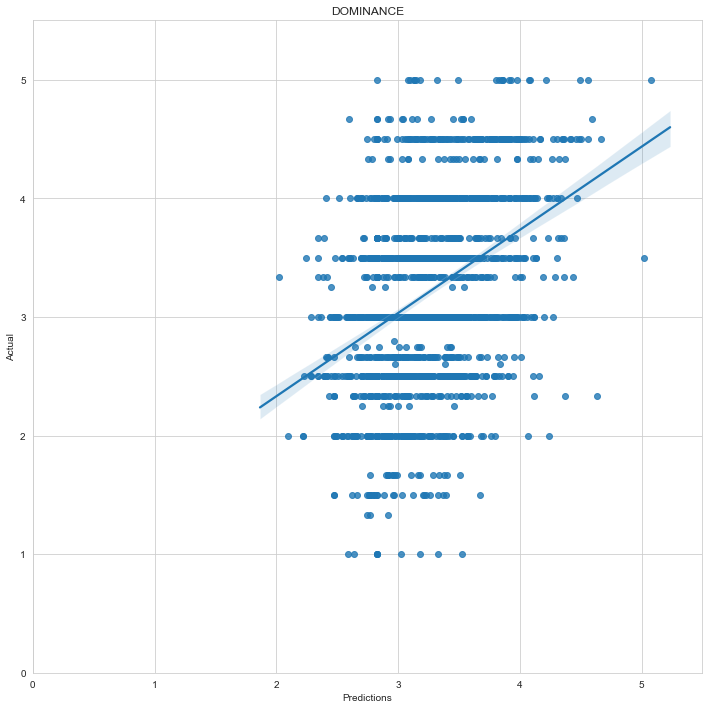

In [10]:
'''
DOMINANCE
'''
# Run the regression and generate predictions for the dev set
# reg_D = Ridge(alpha=.1)
# reg_D.fit(data_train, lab_train_D)
# predictions_D = reg_D.predict(data_dev)
# Print prediction error and plot distribution
# print_preds_errors_plots(predictions_D, lab_dev_D, "DOMINANCE")

# Test set
reg_D = Ridge(alpha=.1)
reg_D.fit(data_training, lab_training_D)
predictions_D = reg_D.predict(data_test)
# Print prediction error and plot distribution
print_preds_errors_plots(predictions_D, lab_test_D, "DOMINANCE")

In [ ]:
'''
SAVE MODELS
'''

joblib.dump(reg_V, 'model_text_valence_iemocap.pkl')
joblib.dump(reg_A, 'model_text_activation_iemocap.pkl')
joblib.dump(reg_D, 'model_text_dominance_iemocap.pkl')

In [11]:
'''
Build a basic CNN
'''

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.0.0


In [13]:
'''
LOAD FILES
'''

# LOAD
with open('/Volumes/COLESLAW_1TB/BELL_LABS/iemocapS1_audio.data', 'rb') as new_data:
    all_data = pickle.load(new_data)

# LOAD
with open('/Volumes/COLESLAW_1TB/BELL_LABS/iemocapS1_labels.data', 'rb') as new_data:
    all_labels = pickle.load(new_data)

# LOAD
with open('/Volumes/COLESLAW_1TB/BELL_LABS/unique_wavs_VAD.data', 'rb') as new_data:
    all_unique_labels = pickle.load(new_data)

print(len(all_data))
print(len(all_labels))
print(len(all_unique_labels))

2146661
2146661
10037


In [21]:
# Pick out VAD labels for each unique .wav
all_val = []
all_act = []
all_dom = []

for e in range(len(all_labels)):
    # for every unique .wav
    lookup = all_labels[e][:-4]
    # pick out the label and append it to a list
    all_val.append(all_unique_labels.loc[lookup]['label_val'])
    all_act.append(all_unique_labels.loc[lookup]['label_act'])
    all_dom.append(all_unique_labels.loc[lookup]['label_dom'])
    
    if (e % 21466 == 0):
        comp = (e / len(all_labels)) * 100
        print("DONE % = ", round(comp))

# Make dataframe of all individual wavs and corresponding labels
all_labels_df = pd.DataFrame([all_labels, all_val, all_act, all_dom]).T
all_labels_df.columns = ['wav_name', 'V', 'A', 'D']

DONE % =  0
DONE % =  1
DONE % =  2
DONE % =  3
DONE % =  4
DONE % =  5
DONE % =  6
DONE % =  7
DONE % =  8
DONE % =  9
DONE % =  10
DONE % =  11
DONE % =  12
DONE % =  13
DONE % =  14
DONE % =  15
DONE % =  16
DONE % =  17
DONE % =  18
DONE % =  19
DONE % =  20
DONE % =  21
DONE % =  22
DONE % =  23
DONE % =  24
DONE % =  25
DONE % =  26
DONE % =  27
DONE % =  28
DONE % =  29
DONE % =  30
DONE % =  31
DONE % =  32
DONE % =  33
DONE % =  34
DONE % =  35
DONE % =  36
DONE % =  37
DONE % =  38
DONE % =  39
DONE % =  40
DONE % =  41
DONE % =  42
DONE % =  43
DONE % =  44
DONE % =  45
DONE % =  46
DONE % =  47
DONE % =  48
DONE % =  49
DONE % =  50
DONE % =  51
DONE % =  52
DONE % =  53
DONE % =  54
DONE % =  55
DONE % =  56
DONE % =  57
DONE % =  58
DONE % =  59
DONE % =  60
DONE % =  61
DONE % =  62
DONE % =  63
DONE % =  64
DONE % =  65
DONE % =  66
DONE % =  67
DONE % =  68
DONE % =  69
DONE % =  70
DONE % =  71
DONE % =  72
DONE % =  73
DONE % =  74
DONE % =  75
DONE % =  76
DONE % = 

In [24]:
# Make dataframe of all individual wavs and corresponding labels
all_labels_df = pd.DataFrame([all_labels, all_val, all_act, all_dom]).T
all_labels_df.columns = ['wav_name', 'V', 'A', 'D']


'''
TRAIN AND TEST SETS
'''

X_train, X_test, y_train, y_test = train_test_split(all_data,
                                                    all_labels_df,
                                                    test_size=0.2,
                                                    random_state=42)

In [28]:
'''
RESHAPE TO PREPARE FOR INPUT TO CNN
'''

nRows,nCols,nDims = 20, 25, 1
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_train = X_train.reshape(X_train.shape[0], nRows, nCols, nDims)
X_test = X_test.reshape(X_test.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Labels for VAD
y_train = np.asarray([y_train['V'], y_train['A'], y_train['D']]).T
y_test = np.asarray([y_test['V'], y_test['A'], y_test['D']]).T
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1717328, 20, 25, 1)
(429333, 20, 25, 1)
(1717328, 3)
(429333, 3)


In [31]:
'''
CREATE A SIMPLE MODEL
'''
# define architecture
def createModel():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

# create the model
model = createModel()

# print a summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20, 25, 64)        128       
_________________________________________________________________
dense_1 (Dense)              (None, 20, 25, 64)        4160      
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 96003     
Total params: 100,291
Trainable params: 100,291
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Lets just run this for 2 epochs to test
EPOCHS = 2

# Fit the model
mod_history = model.fit(
        X_train, y_train, epochs=EPOCHS, validation_split = 0.2,
        verbose=1, callbacks=[tfdocs.modeling.EpochDots()]
        )

Train on 1373862 samples, validate on 343466 samples
Epoch 1/2
1373792/1373862 [============================>.] - ETA: 0s - loss: 0.5934 - mae: 0.6250 - mse: 0.5934
Epoch: 0, loss:0.5934,  mae:0.6250,  mse:0.5934,  val_loss:0.5816,  val_mae:0.6153,  val_mse:0.5816,  
1373862/1373862 [==============================] - 453s 329us/sample - loss: 0.5934 - mae: 0.6250 - mse: 0.5934 - val_loss: 0.5816 - val_mae: 0.6153 - val_mse: 0.5816
Epoch 2/2
1373862/1373862 [==============================] - 470s 342us/sample - loss: 0.5838 - mae: 0.6200 - mse: 0.5838 - val_loss: 0.5791 - val_mae: 0.6161 - val_mse: 0.5791


In [33]:
# Evaluate
mod_evaluate = model.evaluate(X_test, y_test, verbose=2)
print(mod_evaluate)

# Make predictions on the test set
y_pred = model.predict(X_test, batch_size=32, verbose=2)

429333/1 - 43s - loss: 0.5869 - mae: 0.6157 - mse: 0.5781
[0.5781153483968378, 0.6157191, 0.57811564]
429333/1 - 49s


Prediction error:  0.7456798786519288
Mean error:  0.7630001954096207
Pearsons correlation: 0.136
Spearmans correlation: 0.132


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


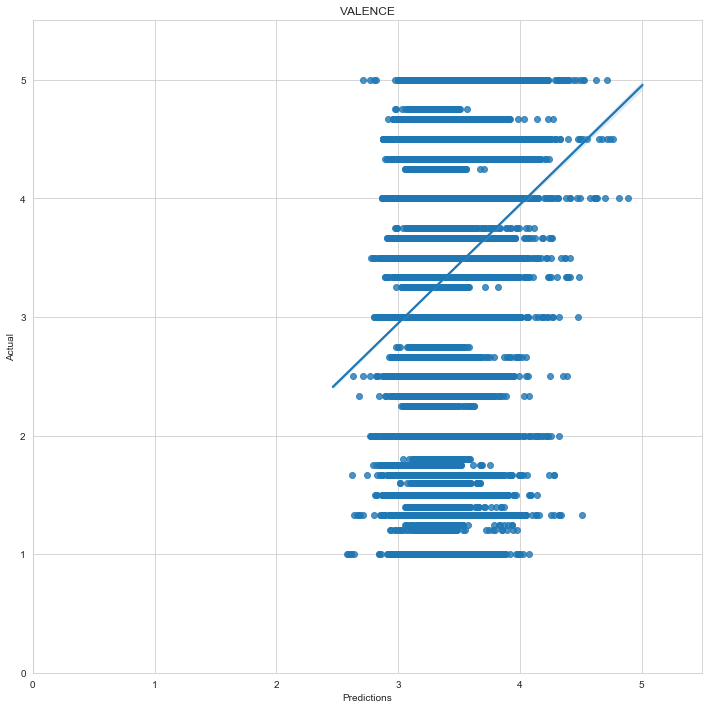

Prediction error:  0.500729186430653
Mean error:  0.5865843609664254
Pearsons correlation: 0.491
Spearmans correlation: 0.493


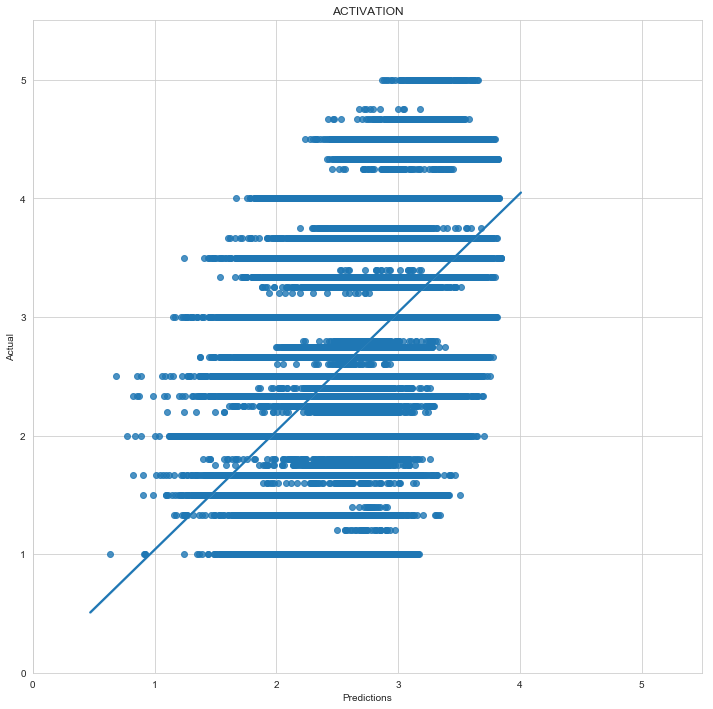

Prediction error:  0.6007462209086013
Mean error:  0.6560541437547805
Pearsons correlation: 0.389
Spearmans correlation: 0.379


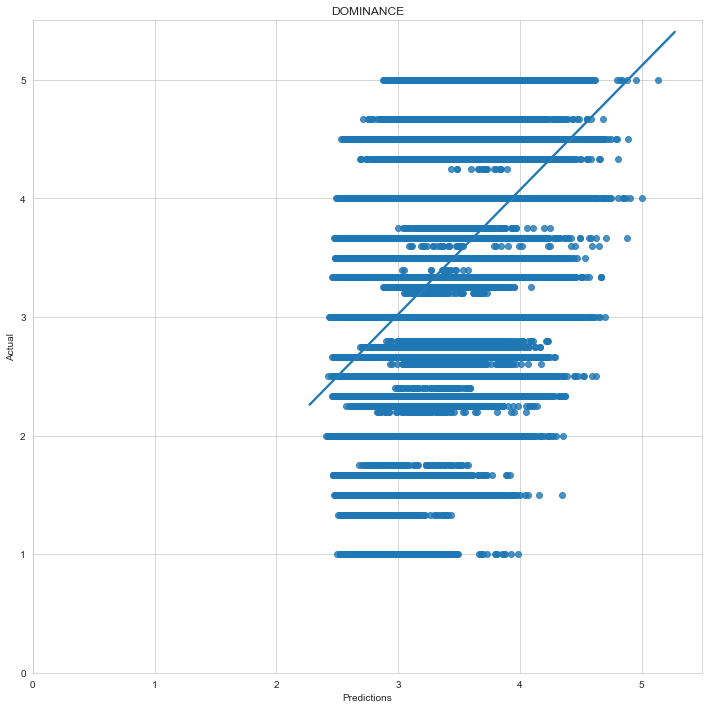

In [34]:
# Print prediction error and plot distribution - test
print_preds_errors_plots(y_pred[:, 0], y_test[:, 0], "VALENCE")
print_preds_errors_plots(y_pred[:, 1], y_test[:, 1], "ACTIVATION")
print_preds_errors_plots(y_pred[:, 2], y_test[:, 2], "DOMINANCE")